In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "compare_trainings_bkg"

In [54]:
# signal = ObjIter([])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])
signal = ObjIter([ Tree(f, report=False) for f in tqdm([module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450]) ])

bkg = ObjIter([])
# bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


In [55]:
# bkg.reweight(2.3)
# bkg.set_systematics(0.2)

In [56]:
def n_presel_jets(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jets)

[None]

In [57]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [47]:
signal = signal.apply(EventFilter('fully res', filter=lambda t : t.nfound_select==8))

In [58]:
path = '/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models'
networks = dict(
    # mp='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221124_ranger_lr0.0047_batch512_m7m10m12/',
    # mpbkg00='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221209_b72001172c5d04183ed7bb294252320b_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg005='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221212_293790a7fbfb752ded05771058bf5a25_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg01='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221209_be9efb5b61eb1c42aeb209728eec84d7_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    
    # mpbkg01_hard25=f'{path}/quadh_ranker_mp/20221214_d595a9703289900d701416bb7274ab71_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg01_hard50=f'{path}/quadh_ranker_mp/20221214_13676d884fa50cdaffb748fc057f180a_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',

    # mpbkg01_hard25=f'{path}/quadh_ranker_mp/20221215_d595a9703289900d701416bb7274ab71_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg01_hard50=f'{path}/quadh_ranker_mp/20221215_13676d884fa50cdaffb748fc057f180a_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg01_hard50_unweighted=f'{path}/quadh_ranker_mp/20221216_dbe056a55e82ce1d89e004942c741bb3_ranger_lr0.0047_batch1024_m7m10m12_unweighted_withbkg/',
    mpbkg01_hard50_new=f'{path}/quadh_ranker_mp/20221218_dbe056a55e82ce1d89e004942c741bb3_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg01_soft50=f'{path}/quadh_ranker_mp/20221216_3670efc07d75e8ee127d257f9fcf66fb_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',

    # mpbkg01_exp=f'{path}/quadh_ranker_mp/20221214_2f889467cb0f6c7a9269c92e93c25c1d_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg05_exp=f'{path}/quadh_ranker_mp/20221214_34452fc51690ae1d20a150a10c0bafa7_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
)

In [59]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)

class Networks:
    def __init__(self, signal, bkg, data, quadh_path=None):
        self.signal = signal.copy()
        self.bkg = bkg.copy()
        self.data = data.copy()

        self.quadh_path = quadh_path

        (self.signal+self.bkg+self.data).apply(lambda t : eightb.load_quadh(t, quadh_path), report=True)
        self.signal.apply(nfound_higgs)

        event_filter = FilterSequence(
            eightb.selected_jet_pt(),
            eightb.selected_jet_btagwp()
        )

        # self.signal = self.signal.apply(event_filter)
        # self.bkg = self.bkg.apply(event_filter)
        # self.data = self.data.apply(event_filter)

In [60]:
models = {
    key : Networks(signal, bkg, data, path)
    for key, path in networks.items()
}

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


In [61]:
model = models['mpbkg01_hard50_new']

In [62]:
t = model.signal[0]

100%|██████████| 1/1 [00:00<00:00, 36.53it/s]


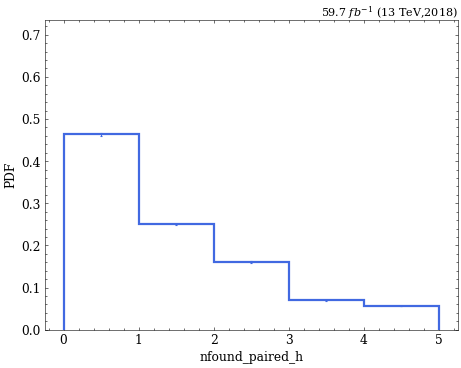

In [64]:
study.quick(
    model.signal,
    # masks=lambda t : t.nfound_select==8,
    varlist=['nfound_paired_h'],
    efficiency=True,
)